<a href="https://colab.research.google.com/github/Tobi-KL/mobility_profile_generation/blob/main/Mobility_Profile_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preparation

Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import csv
!pip install xlrd
import xlrd
import random

Read Data

In [ ]:
###   Read data    ###
# data_mop.pkl: Aggregationsmethode "immer die längste Aktivität"
# data_mop_priority: Aggregationsmethode "priority" (immer die Mobilitätsaktivität)

with open('/content/drive/MyDrive/Tobias_MA/Data/data_mop_priority.pkl', 'rb') as input:
        [states_mop,speed_mop,meta_mop,meta_header_mop] = pickle.load(input)

In [ ]:
# nach Jahr 2017 filtern:
meta_mop_filtered = meta_mop[-3820:-1,]
states_mop_filtered = states_mop[-3820:-1,]
speed_mop_filtered = speed_mop[-3820:-1,]

In [ ]:
state_names = ['not known (mobile or not mobile)', 'work', 'work', 'school,training',
               'shopping', 'private', 'bring,pick up', 'freetime', 'home', 
               'else (outside not mobile)', 'not known (not mobile)', 'by foot', 
               'bicycle', 'motorcycle', 'car driver', 'car codriver', 'public transport', 
               'long distance public-transport', 'else (mobile)', 'not known (mobile)']

no_states = int(len(np.unique(states_mop)))
timesteps = int(states_mop.shape[1])

"""
States:
0:not known (mobile or not mobile)
1:work
2:work
3:school,training
4:shopping
5:private
6:bring,pick up
7:freetime
8:home
9:else (outside not mobile)
10:not known (not mobile)
11:by foot 
12:bicycle
13:motorcycle
14:car driver
15:car codriver
16:public transport
17:long distance public-transport
18:else (mobile)
20:not known (mobile)
"""

'\nStates:\n0:not known (mobile or not mobile)\n1:work\n2:work\n3:school,training\n4:shopping\n5:private\n6:bring,pick up\n7:freetime\n8:home\n9:else (outside not mobile)\n10:not known (not mobile)\n11:by foot \n12:bicycle\n13:motorcycle\n14:car driver\n15:car codriver\n16:public transport\n17:long distance public-transport\n18:else (mobile)\n20:not known (mobile)\n'

In [ ]:
# TANK-Tabelle(2017-2018) einlesen:

with open('/content/drive/MyDrive/Tobias_MA/Data/TANK18.csv') as tank_csv:
  tank_object = csv.reader(tank_csv, delimiter=',')
  #for row in tank_object:
    #print(row)


### Classes

In [395]:
# erstellt ein Haushalt-Objekt
# enthält Informationen über den gewählten Haushalt (Anzahl Bewohner, Anzahl Fahrer, alle Mobilitätsprofile der Bewohner, Position im Datensatz ... )
# vorerst: entweder zufällig oder mit bekannter ID
# TODO: Eingabemöglichkeit verschiedener Parameter (z.B. Haushaltsgröße, Einkommen etc.) -> Rückgabe einer Liste der ähnlichsten Haushalte (set-Methoden)

class Household:
    def __init__(self, household_ID):
        self.household_ID = household_ID
        #self.household_size = household_size
        self.position = np.where(meta_mop_filtered[:,0] == self.household_ID)[0]
        self.chosen_household = meta_mop_filtered.astype(int) [np.where(meta_mop_filtered[:,0] == self.household_ID)]

        """
        - Constructor of household object
        - householdID: ID of household (MOP-Data) -> sorted in ascending order
        - householdSize: # of occupants of household
        """
  
    def get_household(self):
      return self.chosen_household.astype(int)
    # returns chosen household (array with >= 1 entries (1 entry = 1 person, 1 year))

    def get_number_of_occupants(self):
      return self.chosen_household[0,5]
    # returns number of occupants living in chosen household
    
    def get_number_of_drivers(self):
      states = self.get_states(0,1008) # betrachte states in der ganzen Woche
      number_of_drivers = 0
      for i in range(0,len(states)):
        if ((states[i]==14).sum() > 0):
          number_of_drivers += 1
      return number_of_drivers
    # returns number of drivers (at least one state == 14) living in chosen household

    def get_drivers(self):
      states = self.get_states(0,1008) # betrachte states in der ganzen Woche
      drivers_list = []
      for i in range(0,len(states)):
          if ((states[i]==14).sum() > 0):
            drivers_list.append(self.get_data_position()[i])
      return drivers_list
    # returns list of all drivers of chosen household
    
    def get_number_of_cars(self):
      return self.chosen_household[0,7]
    # returns number of cars of chosen household
    
    def get_data_position(self):
      position_list = []
      for i in self.position:
          position_list.append(i)
      return position_list
    # returns indeces of chosen household in data set
    
    def get_states(self, start, end):
      for i in self.position:
        return states_mop_filtered[self.position,start:end]
    # returns all states for timespace between start and end

    def get_speeds(self, start, end):
      for i in self.position:
        return speed_mop_filtered[self.position,start:end]
    # returns all speeds for timespace between start and end

    def get_persons (self, person_number):
      household_positions = self.get_data_position()
      persons = [Personal_Mobility_Profile (position = i, household_ID = self.household_ID) for i in household_positions]
      return persons[person_number].position
    # returns position of chosen Person-object in data set


#####################


    def check_merge(self):
      if (self.get_number_of_drivers() > self.get_number_of_cars()):
        print("Merge necessary. Start method merge().")
        return True
      else:
        print("No merge necessary.")
        return  False
    # checks whether a mobility profile merge is necessary

    def test(self, person_object):
        persons = person_object.sort_drivers(self)
        for i in persons:
          x = i.get_driver_positions(505, 1008) #driver positions
        return x
    
    def merge(self, person_object):
    # while-Schleife (solange Differenz ungleich 0 -> merge Profile)
    # checke Differenz
    # füge die beiden Fahrer, die am wenigsten fahren, zu einem Profil zusammen (-> states UND speeds)
    # Anzahl driver-1
    # usw.
    # gebe die Personen-Profile zurück
      x = self.get_number_of_drivers()
      while x > self.get_number_of_cars():
        print("merge")
        persons = person_object.sort_drivers(self)
        persons.get_driver_positions(start, end) #driver positions
        x -= 1

In [396]:
# testen, ob 1 Auto, mehrere Fahrer (4301011871)
# testen, ob >1 Auto und mehrere Fahrer

household_1 =  Household(household_ID = 4301011871)
#print('Autos:', household_1.get_number_of_cars())
#print('Drivers:',household_1.get_number_of_drivers())
household_1.check_merge()

Merge necessary. Start method merge().


True

In [397]:
print(household_1.test(person_1))

Drivers sorted in descending order.
[13, 14, 21, 22, 23, 24, 162, 163, 166, 167, 171, 172, 173, 412, 413, 414, 456, 457, 458, 459, 460, 461]


In [433]:
household_1 =  Household(household_ID = 4301011871)

# 1. positions aller driver des HH
drivers = household_1.get_drivers()

# 2. erstelle Array mit Listen aller states (für jeden driver eine Liste)
all_driver_states = np.array([household_1.get_states(0,144)[0]])
for i in range(1, len(drivers)):
  all_driver_states = np.append(all_driver_states, [household_1.get_states(0,144)[i]], axis=0)
print(all_driver_states)
print("new array:")

# 3. betrachte ein array aus den letzten beiden Listen

array = all_driver_states[-2:]
print(array)

# 4. ziehe positions aller 14er aus der letzten Liste heraus

# 5. erzeuge eine neue Liste

# 6. ersetze die letzten beiden Listen des arrays durch die neue Liste

[[ 0  0  0  0  0  0  0  0  0  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10
  10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 14 14 14  8
   8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 15 15  7  7  7  7  7
   7  7  7  7  7  7  7 15 15  8  8  8  8  8  8  8  8 11 11  8  8  8  8  8
   8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
   8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10
  10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  10 10 10 14 14 14 14 14  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
   2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
   2 14 14 14 14  8  8 12  5  5  5  5 12  8  8  8  8  8  8  8  8  8  8  8
   8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8]]
new array:
[[ 0  0  0  0  0  0  0  0  0  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10
  10 10 10 10 10 10 10 1

In [398]:
#list2[0] = list1[0]
list1 = household_1.get_states(505,700)[0]
list2 = household_1.get_states(505,700)[1]

print(list1)
print(list2)

[ 7  7  7  7  7  7  7  7  7  7  7  7  7 15 15  7  7  7  7  7  7 15 15 15
 15  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8 14  7 14 14  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8]
[ 7  7  7  7  7  7  7  7  7  7  7  7  7 14 14  7  7  7  7  7  7 14 14 14
 14  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8 

In [399]:
#list3 = list1 # die states der ersten Person werden behalten. Außer, wenn die andere Person fährt
list3=list1.copy()

list2_14 = [13, 14, 21, 22, 23, 24, 162, 163, 166, 167, 171, 172, 173]

for i in list2_14:
  list3[i] = 14

print(list3)



[ 7  7  7  7  7  7  7  7  7  7  7  7  7 14 14  7  7  7  7  7  7 14 14 14
 14  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8 14  7 14 14  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 14 14  8  8 14 14
  8  8  8 14 14 14  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8]


In [295]:
# erstellt das Mobilitätsprofil EINER Person
# dafür muss die position der Person im Datensatz angegeben werden (erste Zeile im Datensatz = Person 0)

class Personal_Mobility_Profile:
    def __init__(self, position, household_ID):
      self.position = position #position in data
      self.household_ID = household_ID
      self.total_distance = total_distance
       
      if ((self.get_state(0,1008)==14).sum() > 0):
        self.driver_bool = True  #true, wenn person ein Fahrer ist
      else:
        self.driver_bool = False
      
      if self.driver_bool == True:
        list_1 = self.get_driver_positions(start, end) #Liste aller states=14
        speeds_sum = 0
        for i in list_1:
          speeds_sum = speeds_sum + self.get_single_speed(i)     #Summe aller Geschwindigkeiten (state=14) 
        mean_speed = speeds_sum / len(list_1)  # in km/h
        time = len(list_1) * 10 # in min
        distance = mean_speed * time / 60
        self.total_distance = distance
      else:
        self.total_distance = 0   


    """
    - Constructor of Personal_Mobility_Profile Object
    - householdID: ID of household (MOP-Data) -> sorted in ascending order
    - position: position of individual person in data set (first line in data set = person 0)
    """

    def get_state(self, start, end):
        states = states_mop_filtered[self.position,start:end]
        return states
    # returns states for individual persons between start and end

    def get_speed(self, start, end):
        return speed_mop_filtered[self.position,start:end]
    # returns speed for timespace between start and end

    def get_single_speed(self, timestep):
        return speed_mop_filtered[self.position, timestep]
    # returns speed for one single timestep

    def get_adjusted_states(self, start, end):
        states = self.get_state(start,end)
        states_adjusted = np.where((states == 8) | (states == 14) | (states == 1) | (states == 2), states, 30)
        return states_adjusted
    # returns adjusted states for individual person
    # 8: home; 1,2: work; 14: Car driver; 30: rest

    def get_driver_positions(self, start, end):
        list_car_driver = [i for i in range(len(self.get_state(start, end))) if self.get_state(start, end)[i] == 14]
        return list_car_driver
    # returns every position in states where car driver (state=14) = true
    
    def get_total_distance(self, start, end):
      list_1 = self.get_driver_positions(start, end) #Liste aller states=14
      speeds_sum = 0
      for i in list_1:
        speeds_sum = speeds_sum + self.get_single_speed(i)     #Summe aller Geschwindigkeiten (state=14) 
      mean_speed = speeds_sum / len(list_1)  # in km/h
      time = len(list_1) * 10 # in min
      distance = mean_speed * time / 60
      return distance 
    # returns total distance driven by person in the week


    def sort_drivers(self, household_object):
      household_drivers = household_object.get_drivers()
      drivers = []   
      for i in household_drivers:
        drivers.append(Personal_Mobility_Profile(position = i, household_ID = household_ID)) #erstellt für jeden driver ein Personal_Mobility_Profile
      drivers.sort(key=lambda x: x.total_distance, reverse=True)
      sorted_drivers = sorted(drivers, key=lambda x: x.total_distance, reverse=True)
      print("Drivers sorted in descending order by total driving distance (km) in one week.")
      return (sorted_drivers)
    # returns list with all drivers in household sorted in descending order by total distance (in whole week)
    ### testen, ob sortieren funktioniert (-> alle sind in MOP bereits absteigend sortiert!)

In [300]:
# wird aufgerufen, um zu prüfen, ob Mobilitätsprofile von Personen im Haushalt zusammengelegt werden müssen (mehr Fahrer im Haushalt, als Autos)
# führt Zusammenlegung, wenn nötig, durch (Personen mit geringster wöchentlicher Fahrleistung werden solange zusammengelegt, bis Anzahl Fahrer = Anzahl Autos)
# gibt die zusammengelegten Mobilitätsprofile aus
# TODO: Methode merge() noch nicht fertig (muss auf get_total_distance zugreifen)
# TODO: in Household-Klasse verschieben

class Profile_Merge:
    def __init__(self, household_ID, number_of_cars, number_of_drivers, drivers):
      self.household_ID = household_ID
      self.number_of_cars = number_of_cars #Anzahl Autos im Haushalt
      self.number_of_drivers = number_of_drivers #Anzahl Personen im Haushalt
      self.drivers = drivers # Liste aller Personen des Haushalts, die mind. einmal Auto als Fahrer (mind. 2) (Liste aller Indezes aus dem Datensatz)

    """
    - Constructor of Profile_Merge Object
    - householdID: ID of household (MOP-Data) -> sorted in ascending order
    - number_of_cars: total number of cars in household
    - number_of_drivers: total number of drivers in household (at least one state = 14)
    - drivers: list of all drivers in household (at least 2)
    """

    def check_merge(self):
      if (self.number_of_drivers > self.number_of_cars):
        print("Merge necessary. Start method merge().")
      else:
        print("No merge necessary.")
    # checks whether a mobility profile merge is necessary
    
    def merge(self):
    # while-Schleife (solange Differenz ungleich 0 -> merge Profile)
    # checke Differenz
    # füge die beiden Fahrer, die am wenigsten fahren, zu einem Profil zusammen
    # Anzahl driver-1
    # usw.
    # gebe die Personen-Profile zurück
      x= self.number_of_drivers
      while x > self.number_of_cars:
        print("merge")
        x -= 1


In [281]:
# Zuordnung persönliche Mobilitätsprofil(e) zu Auto(s)
# davor muss merge stattgefunden haben -> Anzahl Mobilitätsprofile = Anzahl Autos
# Mobility-Profile mit der höchsten Fahrleistung (MOP W) -> Auto mit höchster Fahrleistung usw.
# Eingabe: alle Mobilitätsprofile der Fahrer, alle Speed-Profile der Fahrer
# Rückgabe: Mobilitätsprofile und Speed-Profile mit zugehöriger Autonummer
# TODO: Methode allocate_profile()

class Allocation:
    def __init__(self, mobility_profiles, speed_profiles):
      self.mobility_profiles = mobility_profiles
      self.speed_profiles = speed_profiles
      #self.cars = cars #man weiß automatisch, wie viele Autos verfügbar, da vorher merge

    """
    - Constructor of Allocation Object
    - mobility_profiles: list of mobility profiles of all household-drivers
    - speed_profiles: list of speed profiles of all household-drivers
    """

    #def allocate_profile (self):
      # Zuordnung Mob.profil zu Auto



In [282]:
# erstellt zu gewünschtem Auto im gewünschten Zeitraum das Mobilitätsprofil
# davor müssen merge und allocation gelaufen sein
# TODO: Methode

class Car_Profile:
    def __init__(self, household_ID, mobility_profile, speed_profile, start, end):
      self.household_ID = household_ID
      self.mobility_profile = mobility_profile # zum Auto gehöriges Mobility-Profile
      self.speed_profile = speed_profile # zum Auto gehöriges Speed-Profile
      self.start = start
      self.end = end
    
    """
    - Constructor of Car-Profile Object
    - householdID: ID of household (MOP-Data) -> sorted in ascending order
    - mobility_profile: mobility profile of car
    - speed_profile: speed profile of car
    - start: start timestep
    - end: end timestep
    """
    
    def get_car_profile_plot(self):
      #print("Profile for the chosen car from household " + self.household_ID + " for timesteps " + self.start + " until " + self.end + " :")
      return plt.plot(self.mobility_profile)
    
    


In [283]:
#class Car_Substitution:
# E-Auto Fahrzeugdaten wie BA von Heinz
   #def __init__(self):
       #self.consumption = consumption 
       #self.household_ID = household_ID
       #self.segment = segment
       


In [284]:
#class Charging_Profile
# zunächst nur die beiden trivialen Ladestrategien
# Angabe, wo mit welcher Ladeleistung geladen werden kann


In [286]:
#class Route:
   # def __init__(self, household_ID, route_ID, departure_time, departure_point, arrival_time, arrival_point, purpose, length):
        

#car_ID -> Zuordnung
#-> MOP W

### Tool

Erstellung eines Haushalt-Objektes:

*   Bsp. für HH mit 1 Person: 4301011562;
*   Bsp. für HH mit mehreren Personen: 4711036120
*   Bsp. für HH mit 3 Fahrern, 3 Autos: 4301011674



In [ ]:
# Erstellung eines Haushalt-Objekts in meta_mop_filtered
# ansonsten: gewünschte ID eingeben

household_1 =  Household(household_ID = 4301011871)
household_1.get_household()

In [318]:
# Anzahl Bewohner des Haushalts
# Anzahl Fahrer im Haushalt
# Anzahl Autos im Haushalt

print('number of occupants in chosen household: ', household_1.get_number_of_occupants())
print('number of drivers in chosen household: ', household_1.get_number_of_drivers())
print('number of cars in chosen household: ', household_1.get_number_of_cars())

number of occupants in chosen household:  2
number of drivers in chosen household:  2
number of cars in chosen household:  1


In [319]:
# Informationen über die Position des Haushalts bzw. der Personen im Datensatz (filtered: nur 2017)
# gibt die Position der gewünschten Person im Datensatz an. (0 = erste Person des HH usw.)

print('The household can be found in the data set at row(s): ', household_1.get_data_position())

person_number = 0     # 0: first person, 1: second person ...
print('Person', person_number, 'can be found in the data set at row: ', household_1.get_persons(person_number))

# gebe drivers aus:
print('Drivers of household:', household_1.get_drivers())

The household can be found in the data set at row(s):  [71, 72]
Person 0 can be found in the data set at row:  71
Drivers of household: [71, 72]


Mobility profile of person 0 :


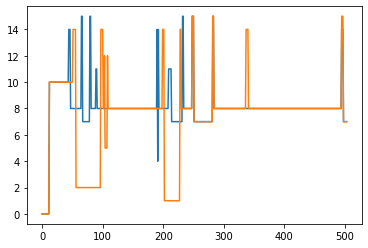

In [324]:
# Ausgabe der Mobilitätsprofile

start = 0    # timesteps
end = 504
person_number = 0

mobility_profiles = household_1.get_states(start,end)

print('Mobility profile of person', person_number, ':')
plt.plot(mobility_profiles[person_number])

In [ ]:
# Ausgabe der Speed-Profiles

start = 0     # timesteps
end = 504
person_number = 0

speed_profiles = household_1.get_speeds(start, end)

print('Speed profile of person', person_number, ':')
plt.plot(speed_profiles[person_number])

In [380]:
# Ausgabe der States eines individuellen HH-Mitglieds
person_number = 1
household_ID = household_1.household_ID
start = 0
end = 504


print('Person', person_number, 'is a driver:', person_1.driver_bool)
print('Person', person_number, 'drove the following total distance (km) in one weeek:', person_1.total_distance)

# Liste aller Positionen "Car Driver":
print('positions where car driver is true:\n', person_1.get_driver_positions(start, end))

# erstelle Personal_Mobility_Profile Objekt:
person_1 = Personal_Mobility_Profile (position = household_1.get_persons(person_number), household_ID = household_ID)
print('original states for person', person_number,':\n', person_1.get_state(start,end))
print('\n')

# setze alle states außer 1,2 (work), 8 (home), 14 (car driver) auf 30
print('adjusted states for person', person_number, ':\n', person_1.get_adjusted_states(start, end))
print('\n')

Person 1 is a driver: True
Person 1 drove the following total distance (km) in one weeek: 12.0
positions where car driver is true:
 [373, 379, 380]
original states for person 1 :
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 14 14 14 14 14  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2 14 14 14 14  8  8 12  5  5  5  5 12  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 14 14  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8 15 15 15  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  

In [337]:
# Sortiere Drivers absteigend nach total distance

x = person_1.sort_drivers(household_object=household_1)
#print(x[1].total_distance)
#print(x[0].household_ID)

Drivers sorted in descending order.
4301011707


### Test

In [ ]:
# Fall: 1 Fahrzeug, mehrere Personen
## Prüfungslogik, ob alle Fahrten nur einem Auto zugeordnet werden können
# alle Arrays abgleichen, ob nie gleichzeitig eine 14 steht
# wenn true -> Fehler gefunden

result = [(x == y == 14) for x,y in zip(household_1.get_states(0,1008)[0], household_1.get_states(0,1008) [1])]
np.any(result)

In [ ]:
# Fahrzeugprofil für das Auto erstellen:
# 3 Personen: 20044, 20045, 20046
# nimmt immer den maximalen Wert
vehicleProfile = mobProfile1

vehicleProfile = np.maximum.reduce([mobProfile1, mobProfile2])

print(vehicleProfile)
print(mobProfile1)

In [ ]:
# Fall 1 Auto, 1 Person (Auto hat das gleiche Mobilitätsprofil, wie die Person)
      if (household.get_number_of_occupants() == 1 and household.get_number_of_cars() == 1):
        print("Car profile for household with 1 Car and 1 Person.")
        #create Person-Object
        #person = Person(0, household_ID)
        #person.get_state(start, end)
        #household.get_persons(0).get_states(start,end)

      
      # Fall 1 Auto, mehrere Personen (Personen solange zusammenlegen, bis Anzahl gleich ist)
      if (household.get_number_of_occupants() > 1 and household.get_number_of_cars() == 1):
        print("Car profile for household with 1 Car and > 1 Person.")
      
      # Fall mehrere Autos, gleich viele Personen
      if (household.get_number_of_cars() > 1 and  household.get_number_of_cars() == household.get_number_of_occupants()):
        print("Car profile for household with >1 Car and the same amount of persons.")

      # Fall mehrere Autos, mehr Personen als Autos (Personen so lange zusammenlegen, bis Anzahl gleich ist)
      if (household.get_number_of_cars() > 1 and  household.get_number_of_cars() > household.get_number_of_occupants()):
        print("Car profile for household with >1 Car and more persons than cars.")

In [ ]:
test_car_profile = Car_Profile (household_ID = 4711036120,  mobility_profile = household_1.get_states(0,1008)[0], speed_profile = household_1.get_speeds(0,1008)[0], start=0, end=1008)
test_car_profile.get_car_profile_plot()

In [ ]:
car_profile_1.get_profile()